In [1]:
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.special import expit
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

### Multiclass Logistic Regression

In [2]:
data = loadmat('../input/andrew_ng/ex3data1.mat')
weights = loadmat('../input/andrew_ng/ex3weights.mat')

In [3]:
data.keys()

dict_keys(['__version__', '__header__', 'X', 'y', '__globals__'])

In [4]:
X, y = data['X'], data['y']

In [5]:
X.shape, y.shape

((5000, 400), (5000, 1))

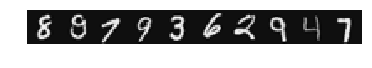

In [6]:
# print 10 random image
ind = np.random.choice(5000, 10)
plt.imshow(X[ind,:].reshape(-1,20).T, cmap='gray')
plt.axis('off');

In [7]:
weights.keys()

dict_keys(['__version__', '__header__', 'Theta2', 'Theta1', '__globals__'])

In [8]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [9]:
# add ones column in the beginning
X = np.c_[np.ones(X.shape[0]), X]
X.shape

(5000, 401)

In [10]:
def sigmoid(z):
    return expit(z)

In [11]:
def cost_reg(theta, X, y, reg):
    m = y.size
    theta = theta.reshape(-1,1)
    hx = sigmoid(X.dot(theta))
    return -(1/m) * (y.T.dot(np.log(hx)) + (1-y).T.dot(np.log((1-hx)))) + reg/(2*m) * theta.T.dot(theta)

In [12]:
def gradient_reg(theta, X, y , reg):
    m = y.size
    theta = theta.reshape(-1,1)
    hx = sigmoid(X.dot(theta))
    a = (1/m) * X.T.dot(hx-y) + np.append(theta[0], (reg/m)*theta[1:]).reshape(theta.size,1)
    return a.flatten()

In [13]:
def one_vs_all(X, y, num_labels, reg):
    m, n = X.shape
    theta = np.zeros((num_labels, n))  # 10X401
    
    for el in np.arange(1, num_labels+1):
        res = minimize(fun=cost_reg, x0=theta[el-1,:], args=(X, (y==el)*1, reg), method=None, jac=gradient_reg)
        theta[el-1] = res.x
    return theta

In [14]:
theta = one_vs_all(X, y, 10, 0.1)

In [15]:
def predict(all_theta, features):
    probs = sigmoid(X.dot(all_theta.T))
    return(np.argmax(probs, axis=1)+1)

pred = predict(theta, X)
'Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100)

'Training set accuracy: 95.92 %'

### Using scikit multiclass logistic regression

In [16]:
log_reg = LogisticRegression(C=10)

log_reg.fit(X[:,1:], y.ravel())  # exclude the ONES column

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
pred = log_reg.predict(X[:,1:])
"Accuracy:{: .2f}%".format(np.mean(pred==y.ravel())*100)

'Accuracy: 96.50%'

### Neural Networks

In [18]:
def nn(X, theta1, theta2):
    a1 = np.c_[np.ones((X.shape[0],1)), X]
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    
    return (np.argmax(a3, axis=1)+1)

pred = nn(X[:,1:], theta1, theta2)
"Accuracy:{: .2f}%".format(np.mean(pred==y.ravel())*100)

'Accuracy: 97.52%'

### Using Tensorflow

In [19]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Refer : https://www.tensorflow.org/get_started/

In [20]:
# create feature column
my_feature_column = []
for el in range(data['X'].shape[1]):
    my_feature_column.append(tf.feature_column.numeric_column(key='col'+str(el)))

In [21]:
batch_size, train_steps = 100, 1000

In [22]:
classifier = tf.estimator.DNNClassifier(hidden_units=[100, 50, 25], feature_columns=my_feature_column, n_classes=10)

In [23]:
# input function
def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    dataset = dataset.shuffle(1000).repeat(count=1000).batch(batch_size)
    
    return dataset

In [24]:
df = pd.DataFrame(np.c_[data['X'], data['y']])
df.columns = ['col'+str(i) for i in range(data['X'].shape[1])]+['class']
df['class'] = df['class'].astype(int)
df['class'] = [0 if i==10 else i for i in df['class']]
df.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col391,col392,col393,col394,col395,col396,col397,col398,col399,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [25]:
classifier.train(input_fn=lambda:train_input_fn(df.iloc[:,:-1], df.iloc[:,-1:].values, batch_size), steps=train_steps)

In [26]:
# evaluate function
def evaluate_input_fn(features, labels, batch_size):
    features = dict(features)
    
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [27]:
eval_result = classifier.evaluate(input_fn=lambda:evaluate_input_fn(df.iloc[:,:-1], df.iloc[:,-1:], batch_size))

In [28]:
eval_result.keys()

dict_keys(['accuracy', 'average_loss', 'global_step', 'loss'])

In [29]:
"Accuracy : {:.2f}%".format(eval_result['accuracy']*100)

'Accuracy : 98.58%'